In [2]:
!pip install dipy

    100% |████████████████████████████████| 7.9MB 2.7MB/s eta 0:00:01
    100% |████████████████████████████████| 3.2MB 1.0MB/s ta 0:00:011
  Running setup.py bdist_wheel for bz2file ... done
  Stored in directory: /home/michal/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built bz2file
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from dipy.tracking.local import LocalTracking, ThresholdTissueClassifier
from dipy.tracking.utils import random_seeds_from_mask
from dipy.reconst.dti import TensorModel
from dipy.reconst.csdeconv import (ConstrainedSphericalDeconvModel,
                                   auto_response)
from dipy.direction import peaks_from_model
from dipy.data import fetch_stanford_hardi, read_stanford_hardi, get_sphere
from dipy.segment.mask import median_otsu
from dipy.viz import actor, window
from dipy.io.image import save_nifti
from nibabel.streamlines import save as save_trk
from nibabel.streamlines import Tractogram
from dipy.tracking.streamline import Streamlines


ImportError: cannot import name 'actor' from 'dipy.viz' (/home/michal/anaconda3/lib/python3.7/site-packages/dipy/viz/__init__.py)

In [3]:
from dipy.viz import *
from dipy.io.image import save_nifti
from nibabel.streamlines import save as save_trk
from nibabel.streamlines import Tractogram
from dipy.tracking.streamline import Streamlines


In [4]:
def show_slice(mr_img, mask = None):
    
    slice_id = mr_img.shape[1] // 2
    slice_img = mr_img[:, slice_id, :]

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(
        slice_img.T, vmax=0.5 * np.max(slice_img), 
        origin='lower', cmap='gray', interpolation='nearest'
    )
    
    if mask is not None:
        slice_mask = mask[:, slice_id]
        
        plt.subplot(1, 2, 2)
        plt.imshow(slice_mask.T, origin='lower', cmap='gray', interpolation='nearest')
    
    plt.show()    

# Load sample dMRI data

Download Progress: [###############################################################################################################################################################] 100.00%  of 87.15 MBDownloading "HARDI150.bval" to /home/michal/.dipy/stanford_hardi
Download Progress: [###############################################################################################################################################################] 100.00%  of 0.00 MBDownloading "HARDI150.bvec" to /home/michal/.dipy/stanford_hardi
Download Progress: [###############################################################################################################################################################] 100.00%  of 0.00 MBFiles successfully downloaded to /home/michal/.dipy/stanford_hardi
Dataset is already in place. If you want to fetch it again please first remove the folder /home/michal/.dipy/stanford_hardi 


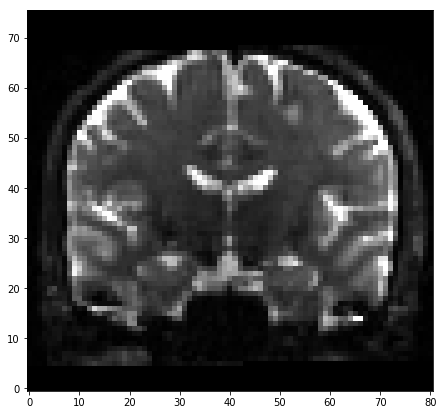

In [5]:
fetch_stanford_hardi()
img, gtab = read_stanford_hardi()
data = img.get_data()

show_slice(data[...,0])

# Model of the diffusion signal

In [6]:
_, mask = median_otsu(data, 3, 1, False, vol_idx=range(10, 50), dilate=2)
response, _ = auto_response(gtab, data, roi_radius=10, fa_thr=0.7)

csd_model = ConstrainedSphericalDeconvModel(gtab, response)
csd_peaks = peaks_from_model(model=csd_model,
                             data=data,
                             sphere=get_sphere('symmetric724'),
                             mask=mask,
                             relative_peak_threshold=.5,
                             min_separation_angle=25,
                             parallel=True)

# Fractional anisotropy

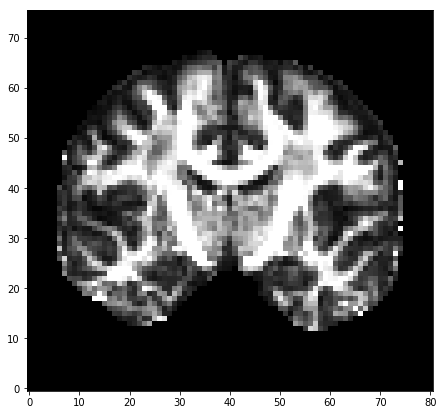

In [7]:
tensor_model = TensorModel(gtab, fit_method='WLS')
tensor_fit = tensor_model.fit(data, mask)

fa = tensor_fit.fa

show_slice(fa)

# White matter mask

TASK: Find optimal threshold value for FA in order to obtain the most accurate white matter mask.

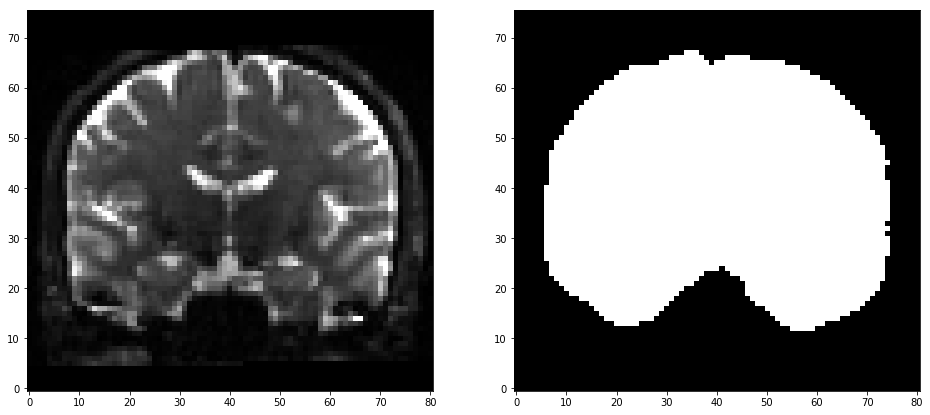

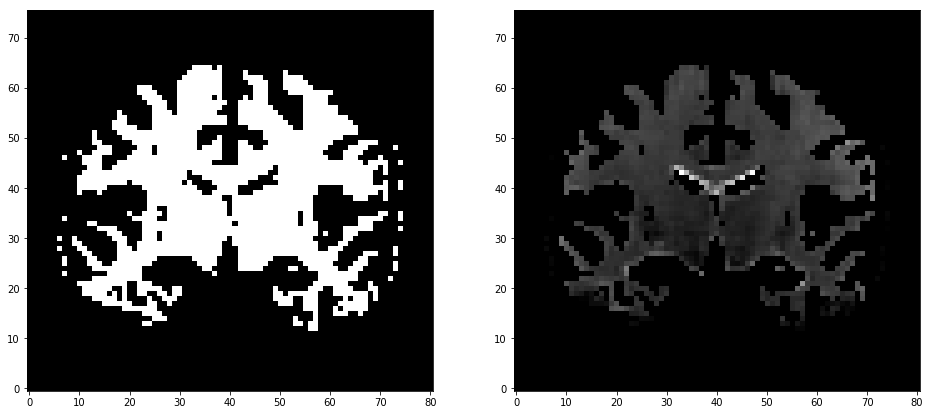

In [31]:
wm_mask = fa > 0.01
wm_mask1 = fa > 0.19
show_slice(data[...,0], wm_mask)
show_slice(wm_mask1, data[...,0]*wm_mask1)

# Run deterministic tractography

In [13]:
tissue_classifier = ThresholdTissueClassifier(fa, 0.1)
seeds = random_seeds_from_mask(wm_mask, seeds_count=1)

streamline_generator = LocalTracking(csd_peaks, tissue_classifier,
                                     seeds, affine=np.eye(4),
                                     step_size=0.5)

streamlines = Streamlines(streamline_generator)



In [14]:
ren = window.Renderer()

ren.clear()
ren.add(actor.line(streamlines))

window.show(ren, size=(900, 900))


NameError: name 'window' is not defined

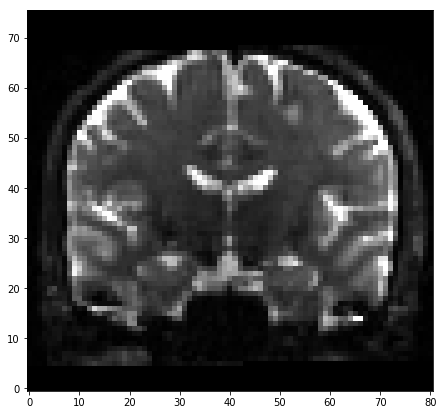

In [9]:
show_slice(data[...,0])